In [1]:
import torch
import torchvision

In [2]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained = True)
model.eval()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:02<00:00, 77.0MB/s]


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [3]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
len(COCO_INSTANCE_CATEGORY_NAMES)

91

In [4]:
from PIL import Image
from torchvision import transforms as T
import numpy as np
import requests
from io import BytesIO

In [5]:
model = model.cuda()

In [16]:
def get_prediction(img_path, threshold = 0.5, url = False):
  if url:
    response = requests.get(img_path)
    img = Image.open(BytesIO(response.content))
  else:
    img = Image.open(img_path)
  transform = T.Compose([
      T.ToTensor()
  ])
  img = transform(img)
  img = img.cuda()
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().cpu().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
  masks = (pred[0]['masks'] > 0.5).squeeze().detach().cpu().numpy()[:pred_t + 1]
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())][:pred_t + 1]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())][:pred_t + 1]
  return masks, pred_boxes, pred_class

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [8]:
import cv2

In [9]:
from urllib.request import urlopen
def url_to_image(url, readFlag = cv2.IMREAD_COLOR):
  resp = urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype = 'unit8')
  image = cv2.imdecode(image, readFlag)
  return image

In [10]:
import random
def random_color_masks(image):
  colors = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180], [250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image == 1], g[image == 1], b[image == 1] = colors[random.randrange(0, 10)]
  colored_mask = np.stack([r, g, b], axis = 2)
  return colored_mask
  

In [20]:
def instance_segmentation(img_path, threshold = 0.5, rect_th = 3, text_th = 3, text_size = 3, url = False):
  masks, boxes, pred_class = get_prediction(img_path, threshold = threshold, url = url)
  if url:
    img = url_to_image(img_path)
  else:
    img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for i in range(len(masks)):
    rgb_mask = random_color_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    pt1 = tuple(int(x) for x in boxes[i][0])
    pt2 = tuple(int(x) for x in boxes[i][1])
    cv2.rectangle(img, pt1, pt2, color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img, pred_class[i], pt1, cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)
  return img, pred_class, masks[i]

In [12]:
!wget https://i.pinimg.com/564x/bb/99/1b/bb991b1ea3c7f91bab4fb8af457c8df8.jpg

--2023-04-12 08:15:28--  https://i.pinimg.com/564x/bb/99/1b/bb991b1ea3c7f91bab4fb8af457c8df8.jpg
Resolving i.pinimg.com (i.pinimg.com)... 104.96.163.211, 104.96.163.196, 2a04:4e42:5::84
Connecting to i.pinimg.com (i.pinimg.com)|104.96.163.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55807 (54K) [image/jpeg]
Saving to: ‘bb991b1ea3c7f91bab4fb8af457c8df8.jpg’

bb991b1ea3c7f91bab4 100%[===================>]  54.50K  --.-KB/s    in 0.01s   

2023-04-12 08:15:28 (4.73 MB/s) - ‘bb991b1ea3c7f91bab4fb8af457c8df8.jpg’ saved [55807/55807]



In [23]:
img, pred_classes, masks = instance_segmentation('owl.jpg', rect_th = 5, text_th = 2)

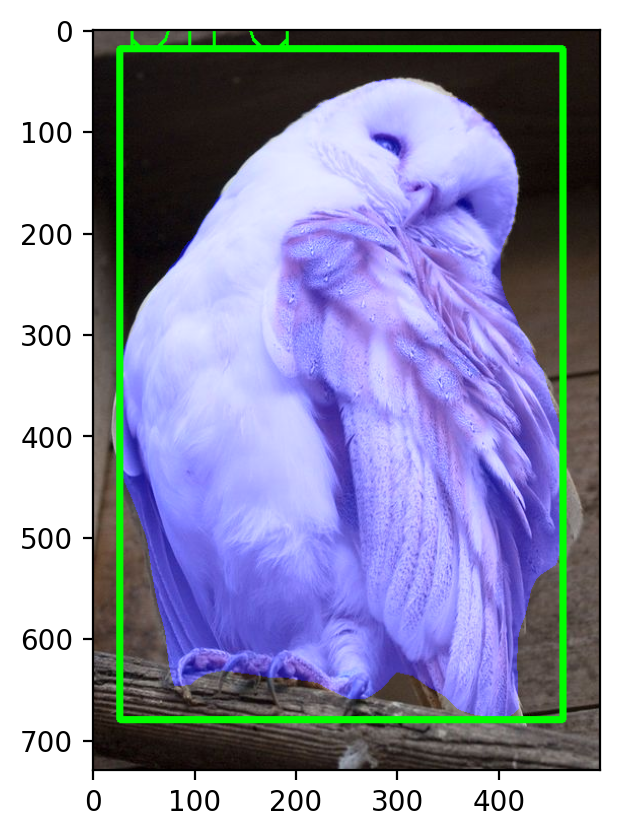

In [24]:
plt.imshow(img)